# **Early Warning Signals in League of Legends**

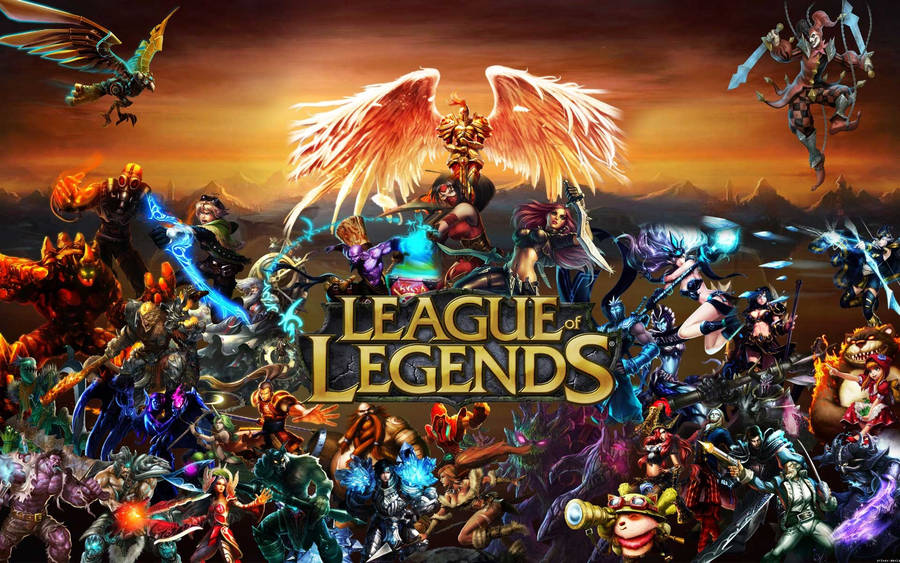

I have enough experience playing ranked matches to experience punch in the gut feeling. After 20 minutes of peaceful play, your team had the lead in gold, and then out of nowhere enemy team pulls off a Baron kill, and your advantage is lost. As somone who wants to win a game, one would even give up all the items in the bag to have heads up that something is gonna happen, like a baron kill or a dragon kill. Using data science techniques, I would like to provide such a heads up to the players.

This project creates a reproducible pipeline, which gathers official data of Riot matches and timelines (data of 2024 - 2025 ranked solo queue), creates team state on a per-10s scale, future game-changing events (Baron/Dragon/Teamfight) are labelled, and trains temporal and composition-sensitive models which issue early warnings. The goal for me is to provide a fully operational demo that you can overlay in-game (replays/live) and be governed before the pivot to reduce the element of surprise, have additional resources to study pre-event phenomena empirically.


### **Few preps to do**

First is to get the API key from the dev portal. Link: https://developer.riotgames.com/

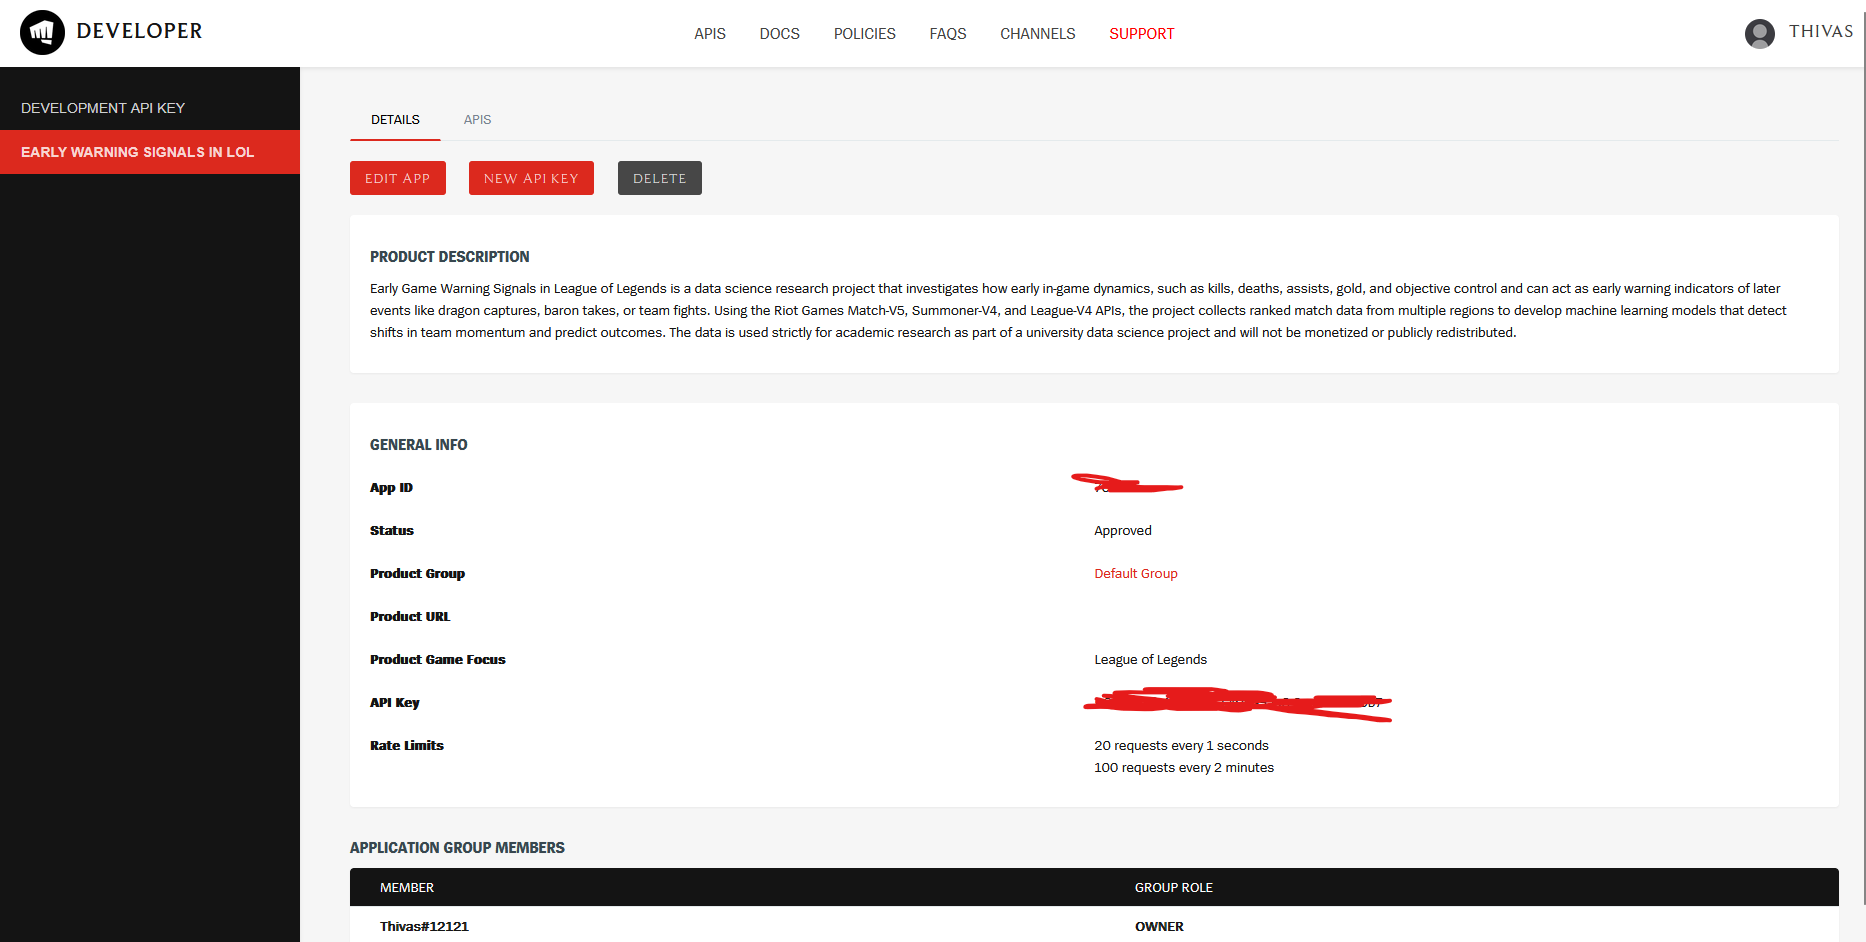

And using riotwatcher library to make it easier to use the API. It makes sure to not get consistent errors while making requests. Documentation Link: https://riot-watcher.readthedocs.io/

## **Loading and inspecting the data**

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
df.head()

,match_id,t,kills_blue_x,kills_red_x,gold_blue,gold_red,xp_blue,xp_red,gold_diff,xp_diff,...,totdmgdealt_blue,totdmgdealt_red,totdmgtochamp_blue,totdmgtochamp_red,totheal_blue,totheal_red,wardsplaced_blue,wardsplaced_red,wardskilled_blue,wardskilled_red
0,EUW1_7402449947,0,0,0,2500,2500,0,0,0,0,...,133034.2,168526.2,17909.8,29443.0,8462.6,7942.6,12.4,15.8,2.6,2.6
1,EUW1_7402449947,10,0,0,2500,2500,0,0,0,0,...,133034.2,168526.2,17909.8,29443.0,8462.6,7942.6,12.4,15.8,2.6,2.6
2,EUW1_7402449947,20,0,0,2500,2500,0,0,0,0,...,133034.2,168526.2,17909.8,29443.0,8462.6,7942.6,12.4,15.8,2.6,2.6
3,EUW1_7402449947,30,0,0,2500,2500,0,0,0,0,...,133034.2,168526.2,17909.8,29443.0,8462.6,7942.6,12.4,15.8,2.6,2.6
4,EUW1_7402449947,40,0,0,2500,2500,0,0,0,0,...,133034.2,168526.2,17909.8,29443.0,8462.6,7942.6,12.4,15.8,2.6,2.6


In [2]:
# Data types and memory usage overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514291 entries, 0 to 1514290
Data columns (total 35 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   match_id            1514291 non-null  object 
 1   t                   1514291 non-null  int64  
 2   kills_blue_x        1514291 non-null  int64  
 3   kills_red_x         1514291 non-null  int64  
 4   gold_blue           1514291 non-null  int64  
 5   gold_red            1514291 non-null  int64  
 6   xp_blue             1514291 non-null  int64  
 7   xp_red              1514291 non-null  int64  
 8   gold_diff           1514291 non-null  int64  
 9   xp_diff             1514291 non-null  int64  
 10  y_baron_10          1477316 non-null  float64
 11  y_baron_20          1477316 non-null  float64
 12  y_baron_30          1477316 non-null  float64
 13  y_dragon_10         1477316 non-null  float64
 14  y_dragon_20         1477316 non-null  float64
 15  y_dragon_30    

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
t,1514291.0,841.946356,531.147685,0.0,400.0,800.0,1240.0,3280.0
kills_blue_x,1514291.0,10.889827,9.775701,0.0,3.0,9.0,17.0,66.0
kills_red_x,1514291.0,10.785733,9.746922,0.0,3.0,9.0,17.0,68.0
gold_blue,1514291.0,25905.754997,18158.038490,2500.0,10169.0,23183.0,39132.0,107025.0
gold_red,1514291.0,25746.750963,18063.499213,2500.0,10129.0,22998.0,38816.0,114461.0
xp_blue,1514291.0,29431.110184,22613.454355,0.0,10223.0,25882.0,45185.0,143014.0
xp_red,1514291.0,29417.508959,22653.442788,0.0,10203.0,25778.0,45189.0,155870.0
gold_diff,1514291.0,159.004034,3482.564598,-19687.0,-1208.0,0.0,1519.0,22474.0
xp_diff,1514291.0,13.601225,4370.284466,-34025.0,-1091.0,0.0,1189.0,31855.0
y_baron_10,1477316.0,0.003885,0.062212,0.0,0.0,0.0,0.0,1.0


In [4]:
df.shape

(1514291, 35)

In [5]:
# Exact duplicate rows
dup_full = df.duplicated().sum()

# Duplicate (match_id, t) entries — should never happen in timeline data
dup_keys = df.duplicated(subset=["match_id", "t"]).sum()

print("Duplicate full rows:", dup_full)
print("Duplicate (match_id, t) rows:", dup_keys)


Duplicate full rows: 0
Duplicate (match_id, t) rows: 0


In [6]:
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(4)

print("Missing value counts:\n", missing_counts)
print("\nMissing value %:\n", missing_percent)


Missing value counts:
 match_id                  0
t                         0
kills_blue_x              0
kills_red_x               0
gold_blue                 0
gold_red                  0
xp_blue                   0
xp_red                    0
gold_diff                 0
xp_diff                   0
y_baron_10            36975
y_baron_20            36975
y_baron_30            36975
y_dragon_10           36975
y_dragon_20           36975
y_dragon_30           36975
y_teamfight_10        36975
y_teamfight_20        36975
y_teamfight_30        36975
kills_blue_y              0
kills_red_y               0
deaths_blue               0
deaths_red                0
assists_blue              0
assists_red               0
totdmgdealt_blue          0
totdmgdealt_red           0
totdmgtochamp_blue        0
totdmgtochamp_red         0
totheal_blue              0
totheal_red               0
wardsplaced_blue          0
wardsplaced_red           0
wardskilled_blue          0
wardskilled_red          

## **Data Quality Diagnosis**

In [7]:
cols = df.columns.tolist()

gold_cols   = [c for c in cols if "gold" in c]
xp_cols     = [c for c in cols if "xp" in c]
kill_cols   = [c for c in cols if "kill" in c]
death_cols  = [c for c in cols if "death" in c]
assist_cols = [c for c in cols if "assist" in c]
vision_cols = [c for c in cols if "ward" in c or "vision" in c]
dmg_cols    = [c for c in cols if "dmg" in c]

print("Gold columns:", gold_cols)
print("XP columns:", xp_cols)
print("Kill columns:", kill_cols)
print("Vision columns:", vision_cols)
print("Damage columns:", dmg_cols)


Gold columns: ['gold_blue', 'gold_red', 'gold_diff']
XP columns: ['xp_blue', 'xp_red', 'xp_diff']
Kill columns: ['kills_blue_x', 'kills_red_x', 'kills_blue_y', 'kills_red_y', 'wardskilled_blue', 'wardskilled_red']
Vision columns: ['wardsplaced_blue', 'wardsplaced_red', 'wardskilled_blue', 'wardskilled_red']
Damage columns: ['totdmgdealt_blue', 'totdmgdealt_red', 'totdmgtochamp_blue', 'totdmgtochamp_red']


In [8]:
nonneg_cols = gold_cols + xp_cols + dmg_cols
for c in nonneg_cols:
    neg = (df[c] < 0).sum()
    if neg > 0:
        print(f"Negative values in {c}: {neg}")


Negative values in gold_diff: 684570
Negative values in xp_diff: 694915


In [9]:
for c in vision_cols:
    frac = (df[c] % 1 != 0).sum()
    if frac > 0:
        print(f"Fractional values in {c}: {frac} rows")


Fractional values in wardsplaced_blue: 1217305 rows
Fractional values in wardsplaced_red: 1197934 rows
Fractional values in wardskilled_blue: 1210597 rows
Fractional values in wardskilled_red: 1216371 rows


In [10]:
event_cols = [c for c in df.columns if any(key in c for key in ["baron_", "dragon_", "teamfight_"])]
print("Detected event label columns:\n", event_cols)
for col in event_cols:
    uniques = df[col].unique()
    if not set(uniques).issubset({0,1}):
        print(f"Non-binary values in {col}: {uniques}")

Detected event label columns:
 ['y_baron_10', 'y_baron_20', 'y_baron_30', 'y_dragon_10', 'y_dragon_20', 'y_dragon_30', 'y_teamfight_10', 'y_teamfight_20', 'y_teamfight_30']
Non-binary values in y_baron_10: [nan  0.  1.]
Non-binary values in y_baron_20: [nan  0.  1.]
Non-binary values in y_baron_30: [nan  0.  1.]
Non-binary values in y_dragon_10: [nan  0.  1.]
Non-binary values in y_dragon_20: [nan  0.  1.]
Non-binary values in y_dragon_30: [nan  0.  1.]
Non-binary values in y_teamfight_10: [nan  0.  1.]
Non-binary values in y_teamfight_20: [nan  0.  1.]
Non-binary values in y_teamfight_30: [nan  0.  1.]


In [11]:
violations = 0
for mid, grp in df.groupby("match_id"):
    diffs = grp["t"].diff().dropna()
    if not (diffs == diffs.iloc[0]).all():
        violations += 1
print("Matches with inconsistent timestamp spacing:", violations)

Matches with inconsistent timestamp spacing: 0


In [12]:
kill_decrease_violations = 0

for c in kill_cols:
    for mid, grp in df.groupby("match_id"):
        if (grp[c].diff().fillna(0) < 0).any():
            kill_decrease_violations += 1

print("Matches with non-monotonic kill counts:", kill_decrease_violations)


Matches with non-monotonic kill counts: 0


## **Cleaning the data**

In [13]:
df = df.drop_duplicates()
df = df.drop_duplicates(subset=["match_id", "t"])

In [14]:
for c in nonneg_cols:
    df[c] = df[c].clip(lower=0)

In [15]:
for col in event_cols:
    df[col] = df[col].apply(lambda x: 1 if x >= 1 else 0)

In [16]:
for c in vision_cols:
    if (df[c] % 1 != 0).any():
        df[c] = df[c].round().astype(int)

In [17]:
df = df.sort_values(["match_id", "t"]).reset_index(drop=True)

In [18]:
if "gold_blue" in df and "gold_red" in df:
    df["gold_diff"] = df["gold_blue"] - df["gold_red"]
if "xp_blue" in df and "xp_red" in df:
    df["xp_diff"] = df["xp_blue"] - df["xp_red"]

## **Final Inspection after cleaning**

In [19]:
print("Final dataset shape:", df.shape)
print("\nRemaining missing values:", df.isnull().sum().sum())
print("\nEvent label distribution:")
print(df[event_cols].sum())

Final dataset shape: (1514291, 35)

Remaining missing values: 0

Event label distribution:
y_baron_10          5740
y_baron_20         11480
y_baron_30         17220
y_dragon_10        31052
y_dragon_20        62104
y_dragon_30        93156
y_teamfight_10    332553
y_teamfight_20    553332
y_teamfight_30    726998
dtype: int64


# **Exploratory Data Analysis**

### **Pre phase**

In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

event_cols = [c for c in df.columns if any(x in c for x in ["baron", "dragon", "teamfight"])]
df["vision_diff"] = df["wardsplaced_blue"] - df["wardsplaced_red"]
df["blue_control"] = (df["vision_diff"] >= 0).astype(int)
df["red_control"]  = (df["vision_diff"] < 0).astype(int)
df["blue_xp_control"] = (df["xp_diff"] >= 0).astype(int)
df["red_xp_control"]  = (df["xp_diff"] < 0).astype(int)
def game_phase(t):
    if t < 600: return "Early Game"
    elif t < 1500: return "Mid Game"
    return "Late Game"
df["phase"] = df["t"].apply(game_phase)

def get_pre_event(df, event_col, horizon=30):
    step = 10
    window_steps = horizon // step
    idx = df.index[df[event_col] == 1]
    pre_rows = []
    for i in idx:
        pre_rows.extend(range(max(0, i-window_steps), i))
    pre_rows = sorted(set(pre_rows))
    pre_df = df.iloc[pre_rows]
    base_df = df.drop(pre_rows).sample(min(len(pre_rows), 3000), replace=True, random_state=42)
    return pre_df, base_df

def kde_curve(series):
    series = series.dropna()
    if len(series) < 50:
        return None, None
    kde = gaussian_kde(series)
    x = np.linspace(series.min(), series.max(), 300)
    return x, kde(x)

### **Objective Threat Timeline | When Big Events Are Likely to Strike**

In [23]:
MIN_MATCHES = 150
match_counts = df.groupby("t")["match_id"].nunique()
valid_ts = match_counts[match_counts >= MIN_MATCHES].index
stable_df = df[df["t"].isin(valid_ts)]
lift_df = stable_df.groupby("t")[event_cols].mean()
lift_df = lift_df.rolling(7, center=True, min_periods=1).mean().reset_index()
lift_df = lift_df[lift_df["t"] <= 2400]
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.08, subplot_titles=("Baron Events", "Dragon Events", "Teamfight Events"))
suffixes = ["10", "20", "30"]
colors = {"10": "red", "20": "blue", "30": "green"}

def add_event_group(fig, row, base_name, show_legend):
    for s in suffixes:
        col_name = f"{base_name}_{s}"
        fig.add_trace(go.Scatter(x=lift_df["t"], y=lift_df[col_name], mode="lines", line=dict(color=colors[s], width=2),
                                 name=s if show_legend else None, showlegend=show_legend), row=row, col=1)
add_event_group(fig, 1, "y_baron", True)
add_event_group(fig, 2, "y_dragon", False)
add_event_group(fig, 3, "y_teamfight", False)

fig.update_layout(height=900, title="Objective Timeline", template="plotly_white")
fig.update_xaxes(title_text="Time (seconds)", row=3, col=1)
for r in [1,2,3]:
    fig.update_yaxes(title_text="Event Probability", row=r, col=1)
fig.show()

### **Gold Advantage Pulse | Tracking Median Lead & Volatility Across the Match**

In [24]:
gold_q = (df.groupby("t")["gold_diff"].quantile([0.1, 0.5, 0.9]).unstack()).rename(columns={0.1:"p10", 0.5:"p50", 0.9:"p90"}).reset_index()
gold_q[["p10","p50","p90"]] = gold_q[["p10","p50","p90"]].rolling(7, center=True, min_periods=1).mean()
gold_q = gold_q[gold_q["t"] <= 2400]
gold_q["spread"] = gold_q["p90"] - gold_q["p10"]
peak_spread_time = gold_q.loc[gold_q["spread"].idxmax(), "t"]
peak_spread_value = gold_q["spread"].max()
peak_median_time = gold_q.loc[gold_q["p50"].idxmax(), "t"]
peak_median_value = gold_q["p50"].max()
fig = go.Figure()
fig.add_trace(go.Scatter(x=gold_q["t"], y=gold_q["p90"], line=dict(width=0)))
fig.add_trace(go.Scatter(x=gold_q["t"], y=gold_q["p10"], fill='tonexty', fillcolor='rgba(100,149,237,0.25)'))
fig.add_trace(go.Scatter(x=gold_q["t"], y=gold_q["p50"],line=dict(color='royalblue', width=3),name="Median Gold Diff"))
fig.add_trace(go.Scatter(x=gold_q["t"], y=gold_q["spread"],line=dict(color='firebrick', width=2, dash="dash"),name="Volatility (P90 - P10)"))
fig.add_vrect(x0=0, x1=600,  fillcolor="gray", opacity=0.05, line_width=0)
fig.add_vrect(x0=600, x1=1500, fillcolor="gray", opacity=0.08, line_width=0)
fig.add_vrect(x0=1500, x1=2400, fillcolor="gray", opacity=0.10, line_width=0)
fig.add_annotation(x=300, y=peak_median_value, text="Early Game", showarrow=False)
fig.add_annotation(x=1050, y=peak_median_value, text="Mid Game", showarrow=False)
fig.add_annotation(x=1950, y=peak_median_value, text="Late Game", showarrow=False)
fig.add_annotation(x=peak_spread_time, y=peak_spread_value, text=f"Max Volatility @ {peak_spread_time}s", showarrow=True, arrowhead=2, yshift=30)
fig.add_annotation(x=peak_median_time, y=peak_median_value,text=f"Peak Median Gold Lead @ {peak_median_time}s", showarrow=True, arrowhead=2, yshift=30)
fig.update_layout(title="Gold Difference Momentum", template="plotly_white",
                  height=600, xaxis_title="Time (seconds)", yaxis_title="Gold Difference")
fig.show()

### **Map Control | Who has more vision?**

In [25]:
vision_balance = df.groupby("t")[["blue_control","red_control"]].mean().reset_index()
vision_balance["balance"] = vision_balance["blue_control"] - vision_balance["red_control"]
vision_balance["balance_smooth"] = vision_balance["balance"].rolling(10, center=True, min_periods=1).mean()
vision_balance = vision_balance[vision_balance["t"] <= 2400]
fig = px.line(vision_balance, x="t", y="balance_smooth", title="Vision Balance Over Time (Blue% − Red%)", template="plotly_white")
fig.update_layout(height=450, xaxis_title="Time", yaxis_title="Vision Balance (−1 to +1)")
fig.show()

### **XP Distribution | Which Team has more hand in the game??**

In [26]:
phase_props = (df.groupby("phase")[["blue_xp_control", "red_xp_control"]].mean().reset_index())
phase_order = ["Early Game", "Mid Game", "Late Game"]
phase_props["phase"] = pd.Categorical(phase_props["phase"], categories=phase_order, ordered=True)
phase_props = phase_props.sort_values("phase")
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "domain"}]*3], subplot_titles=phase_order)
colors = ["red", "blue"]
for idx, phase in enumerate(phase_order):
    values = phase_props.loc[phase_props["phase"] == phase, ["blue_xp_control","red_xp_control"]].values.flatten()
    fig.add_trace(go.Pie(labels=["Blue XP Control", "Red XP Control"], values=values,marker=dict(colors=colors),
                         hole=0.45, textinfo="label+percent"), row=1, col=idx+1)
fig.update_layout(title="XP Control Distribution by Game Phase", template="plotly_white", height=450)
fig.show()

### **Fight Bias Matrix | Where Do Teamfights Break Out?**

In [28]:
df["teamfight_flag"] = df["y_teamfight_10"]
df["blue_xp_ahead"] = (df["xp_diff"] >= 0).astype(int)
grid = (df.groupby(["teamfight_flag", "blue_xp_ahead"]).size().reset_index(name="count"))
grid["Teamfight"] = grid["teamfight_flag"].map({0:"No Fight", 1:"Teamfight"})
grid["XP Lead"] = grid["blue_xp_ahead"].map({0:"Red XP Ahead", 1:"Blue XP Ahead"})
pivot = grid.pivot(index="XP Lead", columns="Teamfight", values="count")
pivot = pivot / pivot.sum().sum()
fig = px.imshow(pivot, text_auto=".1%", color_continuous_scale="Purples", title="Fight Bias")
fig.update_layout(template="plotly_white", height=450)
fig.show()

### **Pre Event Pressure Profiles | What the Game Looks Like Before Key Moments**

In [30]:
# Fix missing column
df["vision_diff"] = df["wardsplaced_blue"] - df["wardsplaced_red"]

features_cont = ["gold_diff", "xp_diff"]
feature_disc = "vision_diff"

# Correct column names
groups = {
    "Baron": "y_baron_30",
    "Dragon": "y_dragon_30",
    "Teamfight": "y_teamfight_30"
}

# Keep only existing columns
groups = {k: v for k, v in groups.items() if v in df.columns}

for title, event_col in groups.items():
    pre_df, base_df = get_pre_event(df, event_col)

    fig = make_subplots(rows=1, cols=3,
                        subplot_titles=["gold_diff", "xp_diff", "vision_diff"])

    # KDE curves for continuous features
    for i, feat in enumerate(features_cont, start=1):
        x_pre, y_pre = kde_curve(pre_df[feat])
        if x_pre is not None:
            fig.add_trace(go.Scatter(
                x=x_pre, y=y_pre, mode="lines",
                name="pre-event", line=dict(color="red")
            ), row=1, col=i)

        x_base, y_base = kde_curve(base_df[feat])
        if x_base is not None:
            fig.add_trace(go.Scatter(
                x=x_base, y=y_base, mode="lines",
                name="baseline", line=dict(color="blue")
            ), row=1, col=i)

    # Discrete vision diff
    vision_bins = sorted(df[feature_disc].unique())

    pre_counts  = pre_df[feature_disc].value_counts(normalize=True).reindex(vision_bins, fill_value=0)
    base_counts = base_df[feature_disc].value_counts(normalize=True).reindex(vision_bins, fill_value=0)

    fig.add_trace(go.Bar(
        x=vision_bins, y=pre_counts.values,
        name="pre-event", marker_color="red", opacity=0.6
    ), row=1, col=3)

    fig.add_trace(go.Bar(
        x=vision_bins, y=base_counts.values,
        name="baseline", marker_color="blue", opacity=0.6
    ), row=1, col=3)

    fig.update_layout(
        title=f"Feature Distributions for {title} (30s Before Event)",
        template="plotly_white",
        height=450, width=1300,
        barmode="overlay"
    )

    fig.show()
